## Problem 1 : Loan document classification

In [59]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read test and train files
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

train.head()

,Label,Text
0,CLOS_DISC,Closing DisclosureThis form is a statement of ...
1,CLOS_DISC,Closing Cost DetailsBorrower-PaidSeller-PaldLo...
2,CLOS_DISC,Calculating Cash to CloseUse this table to see...
3,CLOS_DISC,Additiona Information About This LoanLoan Disc...
4,CLOS_DISC,Loan CalculationsOther DisclosuresTotal of Pay...


In [3]:
test.head()

,Text
0,TRUE & CERTIFIED COPYDAThis form is a statemen...
1,Additional Information About This LoanLoan Dis...
2,Closing Cost DetailsBorrower-PaidSeller-PaidPa...
3,Calculating Cash to CloseUse this table to see...
4,Loan CalculationsOther DisclosuresTotal of Pay...


### Perform EDA

In [4]:
train.shape

(16130, 2)

In [5]:
# Analysis of comment length (min length of message is 6)
train['Text'].str.len().describe()

count    16130.000000
mean      2500.473280
std       1863.212585
min          1.000000
25%       1094.000000
50%       2031.000000
75%       3452.000000
max      14008.000000
Name: Text, dtype: float64

In [6]:
train['Text'][0]

"Closing DisclosureThis form is a statement of final loan terms and closing costs. Compare thisdocument with your Loan Estimate.Closing InformationTransaction InformationLoan InformationDate Issued02/09/2018BorrowerNEELAKANTHA M HARRINGTON andLoan Term30 yearsClosing Date02/09/2018ELIZABETH BERNADINE HARRINGTONPurposePurchaseDisbursement Date02/09/201817300 SW 88TH CTProductFixed RateSettlement AgentENTRUST SOLUTIONS LLCPALMETTO BAY, FL 33157SellerIFLIPPER HOMES LLCFile #1359-16FL-0127Loan TypeXX ConventionalFHA8874 SW 229 SSTProperty17201 SW 90TH AVEMIAMI, FL 33190VAPALMETTO BAY, FL 33157LenderUNITED WHOLESALE MORTGAGELoan ID #1217172251Sale Price$469,999.00MIC #Loan TermsCan this amount increase after closing?Loan Amount$446,499NOInterest Rate5.375%NOCEFTIFY THAT THISIS ATRUE AND CORREC COPYOF THE ORIGINALMonthly Principal & Interest$2,500.27NOEASee Projected Payments below for yourEstimated Total Monthly PaymentDoes the loan have these features?Prepayment PenaltyNOBalloon PaymentNOP

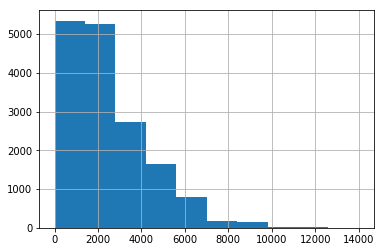

In [7]:
train['Text'].str.len().hist()

In [8]:
# get number of unique labels
train['Label'].nunique()

56

In [9]:
# get frequency count of labels
train['Label'].value_counts()

None                                                       8065
MORTGAGE                                                    891
CREDIT_REPORT                                               754
FORM1003                                                    716
CLOS_DISC                                                   676
APPRAISAL                                                   571
PURCHASE_CONTRACT                                           449
AUS-DU                                                      393
TITLE                                                       383
LOAN_EST                                                    319
NOTE                                                        239
CPL                                                         225
HOMEOWNERSHIP_COUNSELING_ORG_LIST                           222
FORM4506-T                                                  218
WARRANTY_DEED                                               131
VERBAL_VOE                              

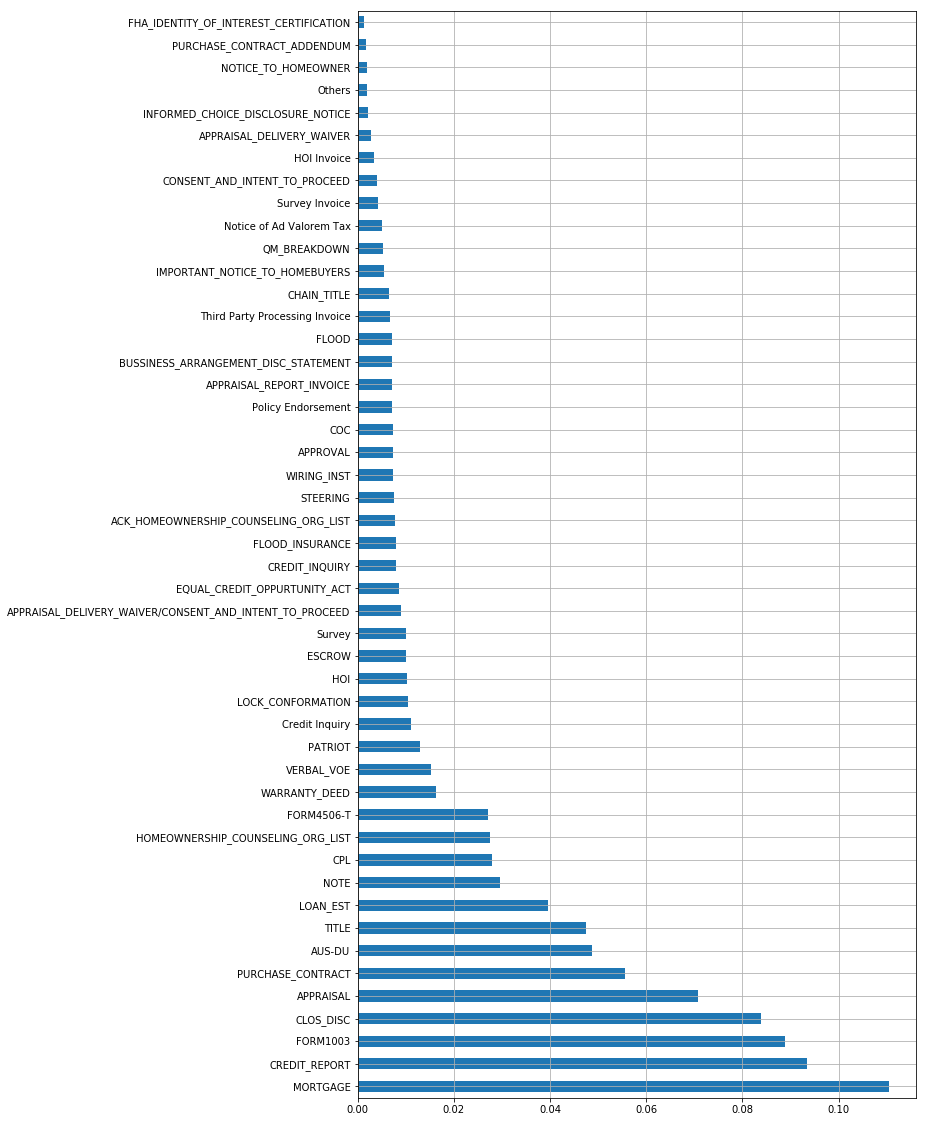

In [58]:
train['Label'].value_counts(normalize=True).plot(kind='barh',grid = True, figsize=(10,20))

In [22]:
# Removing all features that has  None values
train = train[train.Label != 'None']

# relabel as "Others" with < 10 count
train.loc[train.groupby('Label')['Label'].transform('count').lt(10), 'Label'] = "Others"

In [23]:
train['Label'].value_counts()

MORTGAGE                                                   891
CREDIT_REPORT                                              754
FORM1003                                                   716
CLOS_DISC                                                  676
APPRAISAL                                                  571
PURCHASE_CONTRACT                                          449
AUS-DU                                                     393
TITLE                                                      383
LOAN_EST                                                   319
NOTE                                                       239
CPL                                                        225
HOMEOWNERSHIP_COUNSELING_ORG_LIST                          222
FORM4506-T                                                 218
WARRANTY_DEED                                              131
VERBAL_VOE                                                 123
PATRIOT                                                

In [24]:
train.shape

(8065, 2)

In [25]:
import re
import nltk

# process text - white space, special character etc
def norm_docs(doc):
    wp = nltk.WordPunctTokenizer()
    stop_words = nltk.corpus.stopwords.words('english')
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower().strip()
    tokens = wp.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

In [26]:
# normalize train and test data
train['Text'] = train['Text'].apply(lambda x : norm_docs(x))
test['Text'] = test['Text'].apply(lambda x : norm_docs(x))

# char count
train['char_count'] = train['Text'].apply(lambda x : len(x.replace(" ","")))

# word count
train['word_count'] = train['Text'].apply(lambda x : len(x.split()))

# word density
train['word_density'] = train['word_count'] / (train['char_count'] + 1)

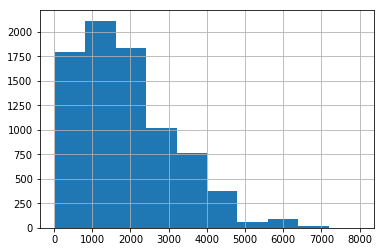

In [27]:
train['char_count'].hist()

In [29]:
# encode target labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y =  le.fit_transform(train['Label'])

In [30]:
# train, test and split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['Text'], y, test_size=0.2,random_state = 0)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(X_train)
X_train = tfv.transform(X_train)
X_test = tfv.transform(X_test)

In [32]:
# fit Support vector classifier
from sklearn.svm import SVC

clf = SVC(kernel='linear', class_weight='balanced',probability=True)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
y_pred = clf.predict(X_test)

In [34]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss
print(classification_report(y_test, y_pred, target_names=train['Label'].unique()))

                                                         precision    recall  f1-score   support

                                              CLOS_DISC       0.94      0.88      0.91        17
                                                   NOTE       0.98      0.99      0.99       125
                                               MORTGAGE       1.00      0.50      0.67         4
                                          WARRANTY_DEED       1.00      0.78      0.88         9
                                            WIRING_INST       1.00      0.78      0.88         9
                                            CHAIN_TITLE       0.92      1.00      0.96        12
                                                  TITLE       0.97      0.97      0.97        75
                               Notice of Ad Valorem Tax       1.00      1.00      1.00        12
                                                    CPL       1.00      0.75      0.86        12
                             

In [35]:
# analyze confusion matrix
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_pred)
cm.imbalance
#print(cm)

True

In [51]:
# produce final output
X_final = tfv.transform(test['Text'])
y_final = clf.predict(X_final)
test['predicted'] = y_final
test.to_csv("Problem_1.csv",index=False)

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(k_neighbors=10, random_state=44, kind = 'svm')
X_res_train, y_res_train = sm.fit_sample(X_train, y_train)